In [1]:
import numpy as np
from expr import *
from simplify import *

In [2]:
def random_binary_expression(depth: int, options):
    if depth == 0:
        if np.random.choice(2) == 0:
            return ConstantExpression(np.random.randint(1, 10))
        else:
            return VariableExpression("x")
    else:
        op = np.random.choice(options["BINARY_OPERATORS"])
        expr = BinaryExpression(op, random_binary_expression(depth - 1, options), random_binary_expression(depth - 1, options))
        if np.random.choice(5) == 0:
            op = np.random.choice(options["UNARY_OPERATORS"])
            expr = UnaryExpression(op, expr)
        return expr

(256 - 3 * x) + x ^ 9 * (x - x)
(256.84059041610476 ^ (0.5414694326385938 ^ x)) ^ ((x / 11.503306617088745) / x ^ x)
0.7511684475403018


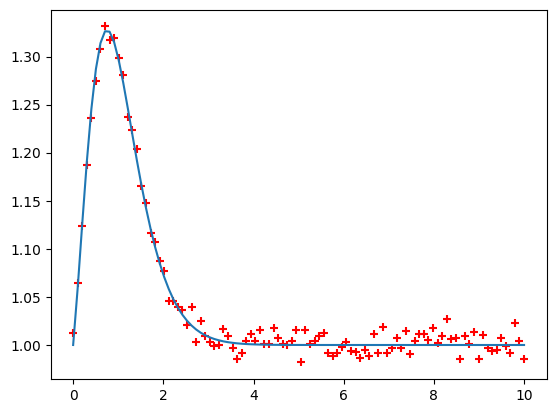

In [3]:
import matplotlib.pyplot as plt

options = { "BINARY_OPERATORS": [ e for e in BinaryOp ], "UNARY_OPERATORS": [ e for e in UnaryOp ] }
expr = random_binary_expression(3, options).simplify()
print(expr)

mutator = SequentialMutator(
    [
        RandomConstantMutator(),
        RandomBinaryOperatorMutator()
    ])
mutator.visit(expr)
print(expr)

N = 100
X = np.linspace(0, 10, N)
Y = expr.evaluate({ "x": X })
Y_NOISE = Y + np.random.normal(size=np.shape(X)[0], scale=np.std(Y) * 0.1)
risk = np.sum(np.abs(Y - Y_NOISE))
print(risk)
plt.plot(X, Y)
plt.scatter(X, Y + np.random.normal(size=np.shape(X)[0], scale=np.std(Y) * 0.1), marker='+', color='red')
plt.show()

# Example

## Input data

In [4]:
N = 1000
X = np.linspace(0, 1, N)
Y = np.sin(4 * X) + 0.5 * X

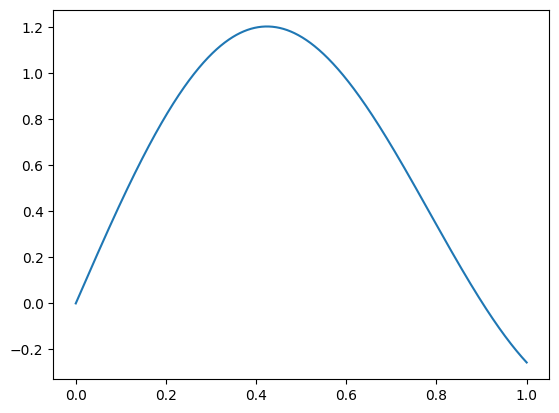

In [5]:
plt.plot(X, Y)
plt.show()

## Regression

In [6]:
import copy

In [16]:
MAX_DEPTH = 3
K_BEST = 5
POPULATION_SIZE = 10000
EPOCHS = 10
OPTIONS = {
    "BINARY_OPERATORS": [ BinaryOp.ADD, BinaryOp.MUL ], 
    "UNARY_OPERATORS": [ UnaryOp.SIN, UnaryOp.SQRT, UnaryOp.TAN ]
}

def loss(formula):
    predicted_y = formula.evaluate({ "x": X })
    l = np.mean((Y - predicted_y) ** 2)
    if np.isnan(l):
        return np.inf
    else:
        return l

formulas = [ random_binary_expression(MAX_DEPTH, OPTIONS) for _ in range(POPULATION_SIZE) ]
best_formula_indices = np.argpartition([ loss(formula) for formula in formulas ], K_BEST)[:K_BEST]
best_formulas = [ formulas[index] for index in best_formula_indices ]
for formula in best_formulas:
    print(formula)

# best_formula = BinaryExpression(BinaryOp.ADD,
#     UnaryExpression(UnaryOp.SIN, 
#                     BinaryExpression(BinaryOp.MUL, 
#                                      ConstantExpression(1), 
#                                      VariableExpression("x"))),
#     BinaryExpression(BinaryOp.MUL,
#                      ConstantExpression(1),
#                      VariableExpression("x")))

p = np.array([ 3, 2, 2, 5, 1 ])
p = p / np.sum(p)
mutator = RandomMutator(
        [ 
            RandomConstantMutator(),
            RandomBinaryOperatorMutator(OPTIONS["BINARY_OPERATORS"]),
            RandomUnaryOperatorMutator(OPTIONS["UNARY_OPERATORS"]),
            RandomUnaryDeleterMutator(p=1),
            RandomBinaryDeleterMutator(p=1)
        ], p)

for i in range(EPOCHS):
    formulas = [ copy.deepcopy(np.random.choice(best_formulas)) for _ in range(int(POPULATION_SIZE * 0.8)) ]
    for _ in range(int(POPULATION_SIZE * 0.2)):
        formulas.append(random_binary_expression(MAX_DEPTH, OPTIONS))

    best_formula = best_formulas[np.argmin([loss(f) for f in best_formulas])]
    print(f"EPOCH {i}: {loss(best_formula)}: {best_formula}")
    for formula in formulas:
        mutator.visit(formula)
    best_formula_indices = np.argpartition([ loss(formula) for formula in formulas ], K_BEST)[:K_BEST]
    best_formulas = [ formulas[index].simplify() for index in best_formula_indices ]

sin(((2 + x) + (x + 9)) + (x * x + 8 * 5))
sin((x * x + (x + 4)) + ((x + 2) + (8 + 5)))
sin(((9 + 9) + x * 2) + ((2 + x) + 9 * 9))
sin(((x + 6) + sin(5 * x)) + sqrt((x + 6) * (6 + 1)))
sin(((7 + 4) + (4 + x)) + ((x + 4) + x * x))
EPOCH 0: 0.033899988373361375: sin(((9 + 9) + x * 2) + ((2 + x) + 9 * 9))
EPOCH 1: 0.014897448151911121: sin((18.744488861076285 + x * 2.3846313279975124) + ((2.4512904167397673 + x) + 16.594965011108407))
EPOCH 2: 0.014897448151911121: sin((18.744488861076285 + x * 2.3846313279975124) + ((2.4512904167397673 + x) + 16.594965011108407))
EPOCH 3: 0.014428234728199612: sin((18.05749787542603 + (x + 2.1451571036182218)) + (2.231117199919953 * x + 17.67139716567462))
EPOCH 4: 0.01436866802424189: sin((18.760041852778723 + x * 2.289904559740639) + ((2.4512904167397673 + x) + 16.615249207602073))
EPOCH 5: 0.01436866802424189: sin((18.760041852778723 + x * 2.289904559740639) + ((2.4512904167397673 + x) + 16.615249207602073))
EPOCH 6: 0.01423507139384347: sin((18.76004

sin(4x) + 0.5x
sin((19.29703144666126 + x * 2.289904559740639) + ((3.1634096273022707 + x) + 15.38096226184941))
0.01423406731101781


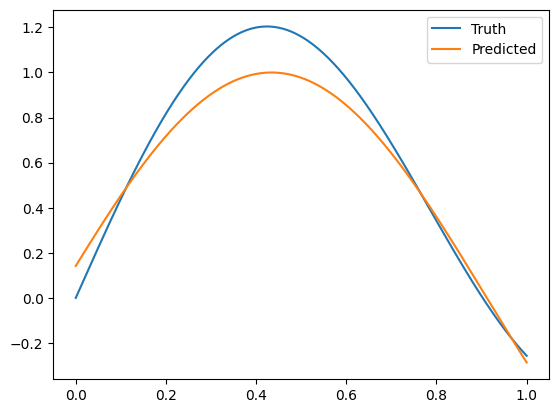

In [17]:
print("sin(4x) + 0.5x")
print(best_formula)
print(loss(best_formula))
plt.plot(X, Y, label="Truth")
plt.plot(X, best_formula.evaluate({ "x": X }), label="Predicted")
plt.legend()
plt.show()